Required packets

In [1]:
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pywt
import pandas as pd

## Wavelet Transform

Apply CWT to match eventually the right seasonality, mother wavelet used is Morlet.

Load the Dataset

In [2]:
series = read_csv('series_normalized.csv', header=0, index_col=0, parse_dates=True).squeeze("columns")

# Create a date range with the same start and end dates and frequency as the original series
time_index = series.index

# prepare data
X = series.values.astype('float32')

Plot

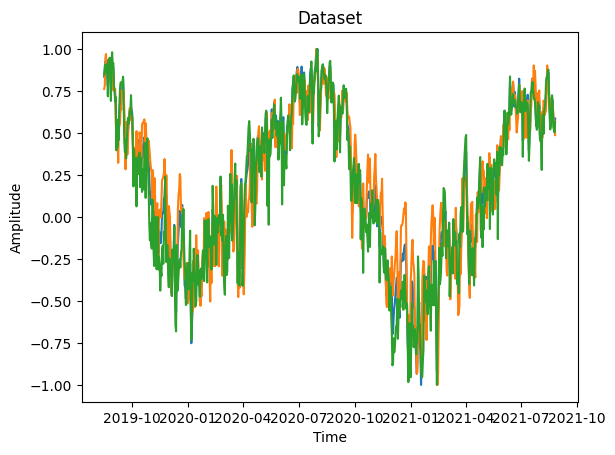

(741, 3)


In [3]:
plt.plot(time_index, X)
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
print(X.shape)

Select the right frequencies and normalize based on sampling frequency

In [4]:
# Calculate the time difference between consecutive timestamps
time_diff = series.index.to_series().diff().min()

# Set dt based on the time difference
dt = time_diff.total_seconds()

# Convert dt to Hertz
fs = 1 / dt

# Define the frequencies for daily to yearly
frequencies = np.array([0.0000115740741, 1.6534391534391535e-06, 4.133597883597884e-07, 3.21502058e-8])

# Select frequencies lower than or equal to the sampling frequency
selected_frequencies = frequencies[frequencies < fs] / fs

Wavelet Transform based on scales obtained from selected frequencies

Create the new dataframe with the coef values for each scale

In [5]:
# Initialize a list to store DataFrames
df_list = []

# Iterate over each dimension of X
for i in range(X.shape[1]):
    # Compute CWT for the current dimension
    scales = pywt.frequency2scale('morl', selected_frequencies)
    coef, freqs = pywt.cwt(X[:, i], scales, 'morl')
    if len(freqs) == 4:
      column_names = ['Daily', 'Weekly', 'Monthly', 'Yearly']
    elif len(freqs) == 3:
      column_names = ['Weekly', 'Monthly', 'Yearly']
    elif len(freqs) == 2:
      column_names = ['Monthly', 'Yearly']
    else:
      column_names = ['Yearly']

    # Create a DataFrame for the coefficients of the current dimension
    df_coef = DataFrame(data=coef.T, index=time_index, columns=[f'{name}_Dimension_{i+1}' for name in column_names])

    # Append the DataFrame to the list
    df_list.append(df_coef)

# Concatenate DataFrames along columns
df_combined = pd.concat(df_list, axis=1)

# Save the combined DataFrame to a CSV file
df_combined.to_csv('coefficents.csv')

Plot the scalogram

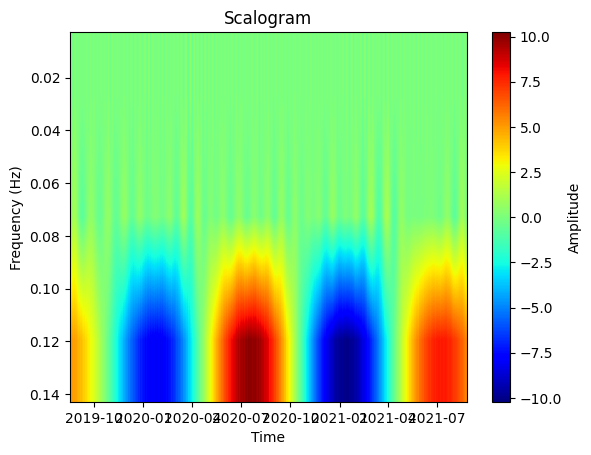

In [6]:
plt.imshow(coef, aspect='auto', extent=[time_index[0], time_index[-1], freqs[0], freqs[-1]], cmap='jet', interpolation='bilinear')
plt.title('Scalogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')
plt.show()

Plot the Wavelet Transform for each scale

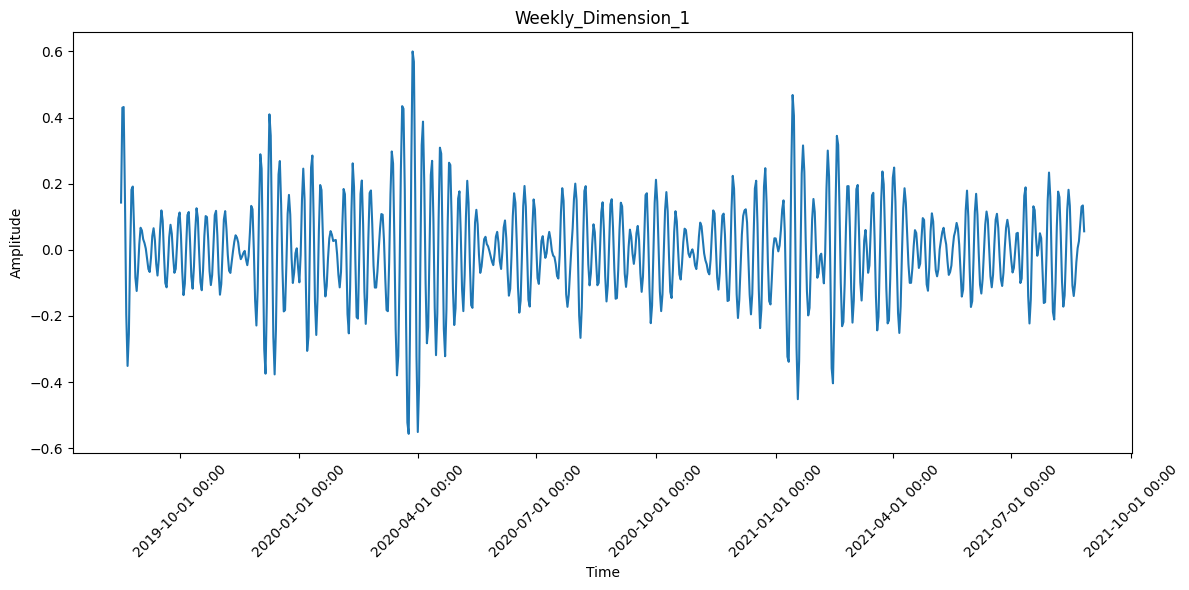

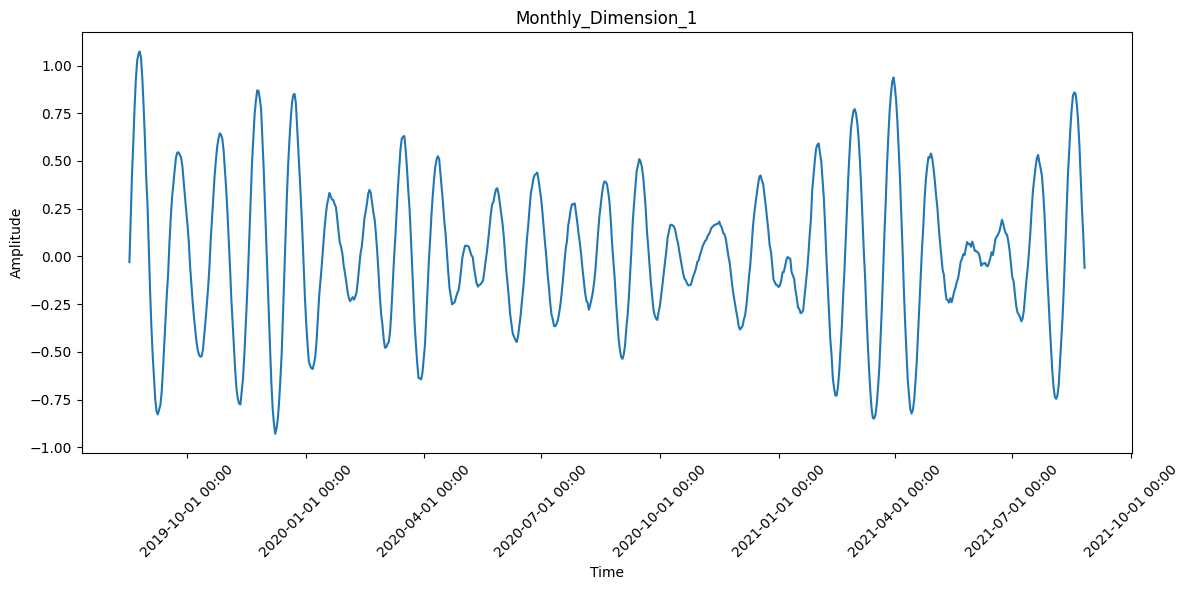

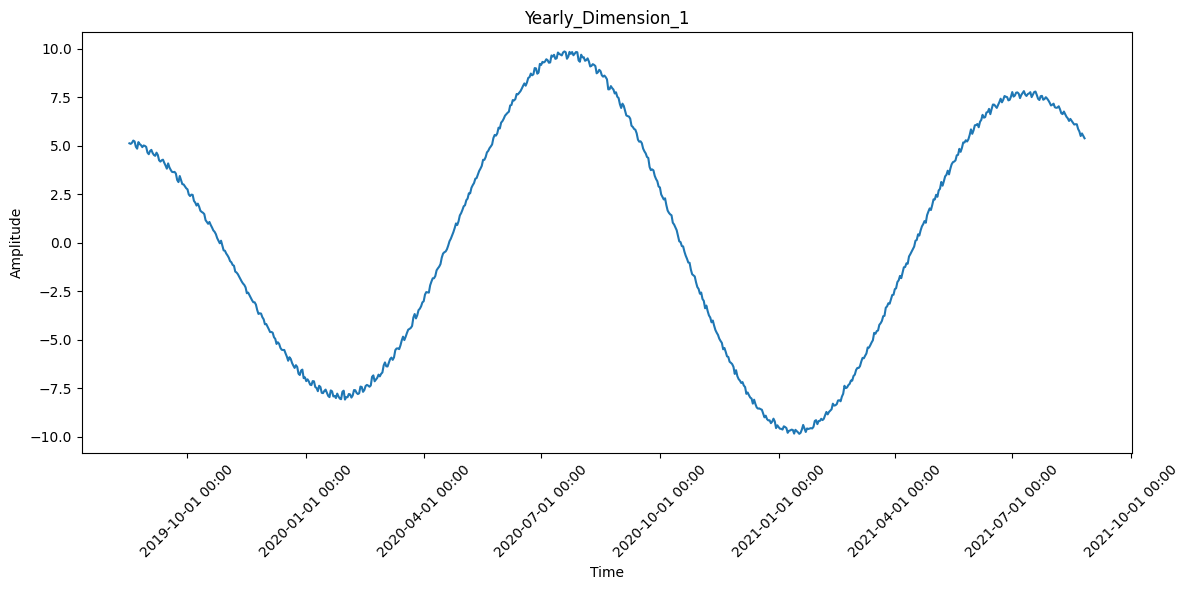

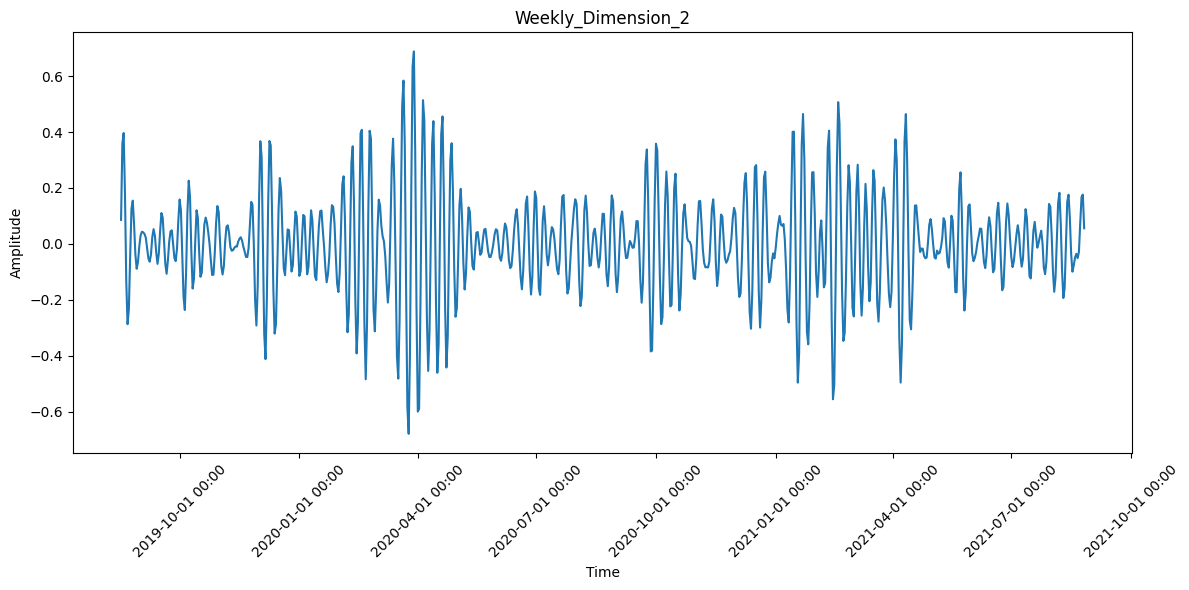

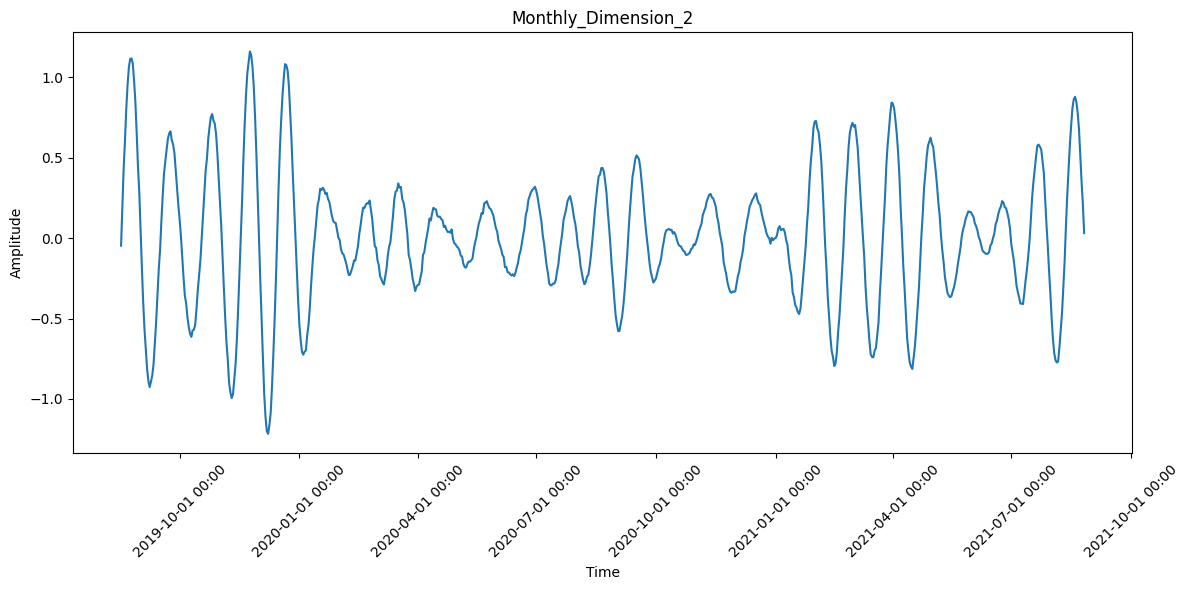

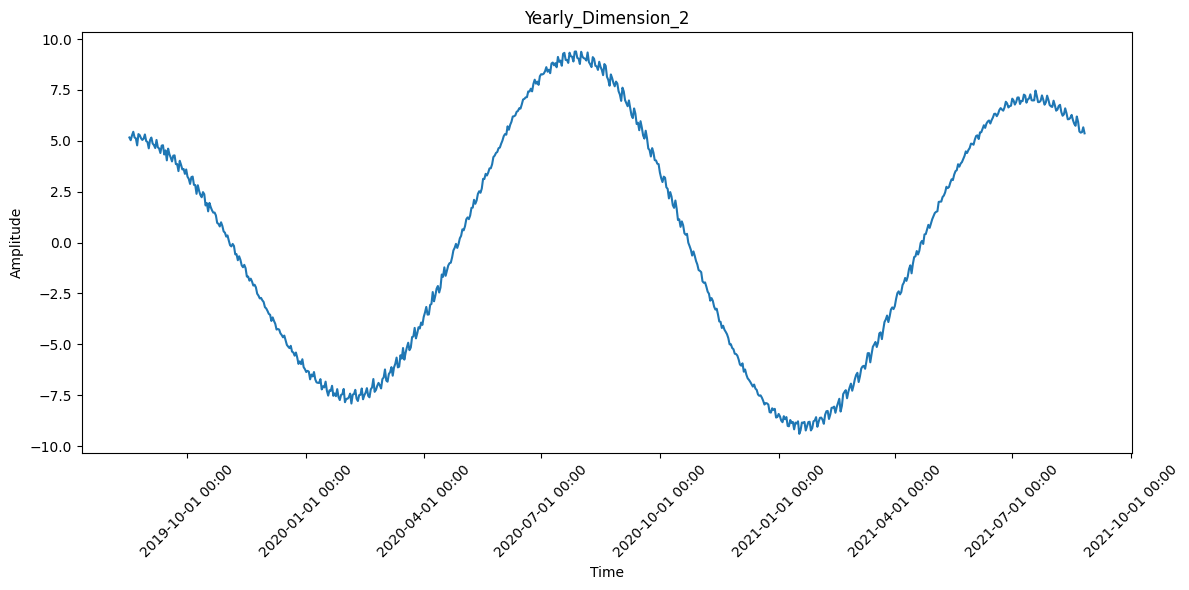

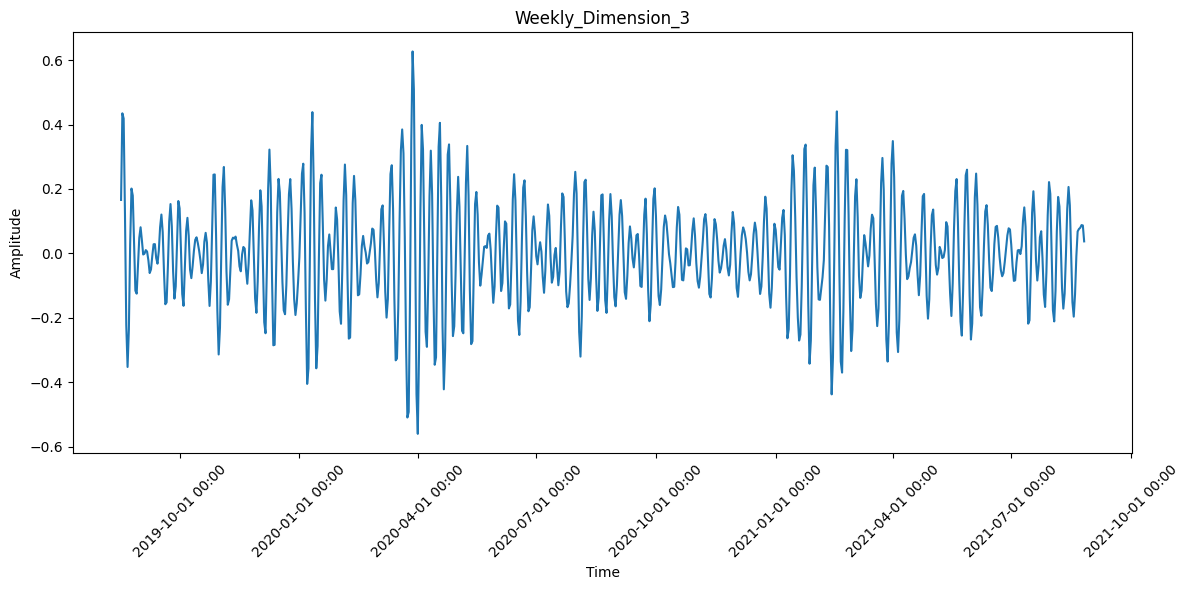

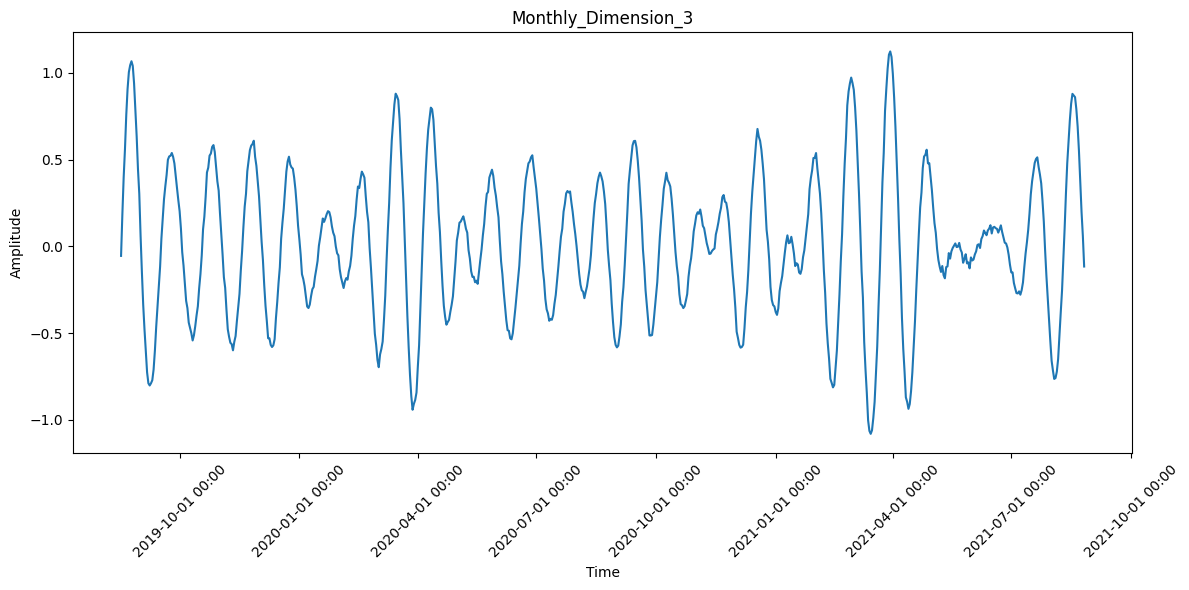

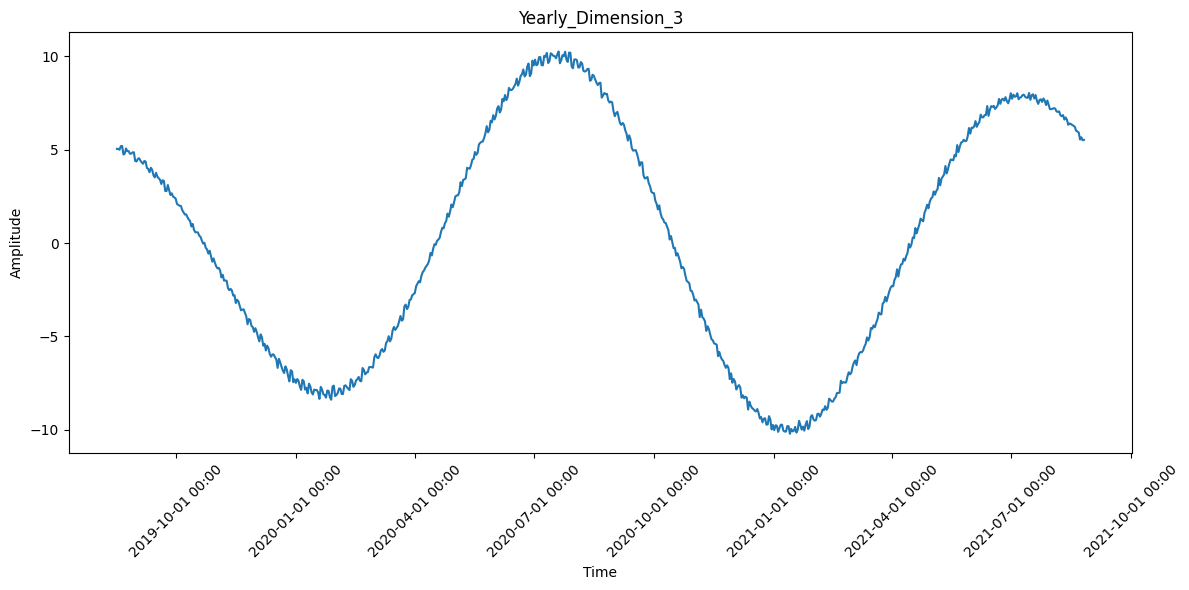

In [7]:
for column in df_combined.columns:
  # plt.plot(time_index, df_combined[column])
  # plt.title(f'{column}')
  # plt.xlabel('Time')
  # plt.ylabel('Amplitude')
  # plt.show()
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(time_index, df_combined[column])
  plt.title(f'{column}')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  # Ruotare e formattare le etichette dell'asse x
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
  plt.xticks(rotation=45)  # Rotazione delle etichette

  plt.tight_layout()
  plt.show()